In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm

from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
#Transmit Power
P=1
#Power splitting ratio
rho = 1
#Power loss of splitter
eps = 1
#variance of antenna noise
w = 1
#rectifier efficiency
eta=1
noise_std = 1
print('number of symbols:',M)


number of symbols: 16


In [4]:
def set_up_train_nn(P,EsNodB):
    
    label = np.random.randint(M,size=N)
    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)
        # checking data shape
    data = np.array(data)
    print (data.shape)
    es = EarlyStopping(monitor='val_loss',patience=15, verbose=1)
    #callbacks = [EarlyStoppingByAccuracy(monitor='accuracy', value=0.98, verbose=1)]
    # Defined Autoencoder
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded = Dense(8,activation='relu')(encoded)
    encoded = Dense(4,activation='relu')(encoded)
    encoded2 = Dense(n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    
    encoded4 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #Add antenna noise
    encoded5 = Lambda(lambda x: x+K.random_normal_variable((2*4096,1), 0, 1)[0:tf.shape(x)[0],:])(encoded4)

    # Making PD data, and applying noise
    pd_data = Lambda(lambda x: K.square(x))(encoded5)

    # Reciever Layer
    decoded = Dense(1, activation='linear')(encoded5)
    decoded = Dense(4,activation='relu')(decoded)
    decoded = Dense(8,activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.05)
    epochs=65
    sgd = SGD(lr=0.075)
    
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    

    # traning auto encoder
    history = autoencoder.fit(data, data,epochs=200,batch_size=2048,callbacks=[es],validation_split=0.3)
    
    
    # list all data in history
    print(history.history.keys())
    
    results = autoencoder.evaluate(data, data, batch_size=2*2048)
    print('test loss, test acc:', results)

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded4)
    
    
    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)
    
    # ploting constellation diagram
    
    

    plt.scatter([i for i in range(0,M)],scatter_plot)
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' P = '+str(P))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)
    
    return autoencoder

(45000, 16)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 31499 samples, validate on 13501 samples
Epoch 1/200
31499/31499 [==============================] - 1s 40us/step - loss: 2.6332 - acc: 0.1016 - val_loss: 2.5734 - val_acc: 0.1070
Epoch 2/200
31499/31499 [==============================] - 0s 3us/step - loss: 2.5791 - acc: 0.1133 - val_loss: 2.5656 - val_acc: 0.1224
Epoch 3/200
31499/31499 [==============================] - 0s 3us/step - loss: 2.5770 - acc: 0.1139 - val_loss: 2.5662 - val_acc: 0.1208
Epoch 4/200
31499/31499 [==============================] - 0s 3us/step - loss: 2.5807 - acc: 0.1118 - val_loss: 2.5651 - val_acc: 0.1164
Epoch 5/200
31499/31499 [==============================] - 0s 3us/step - loss: 2.5760 - acc: 0.1148 - val_loss: 2.5661 - val_acc: 0.1208
Epoch 6/200
31499/31499 [==============================] - 0s 3us/step - loss: 2.5711 - acc: 0.1179 - val_loss: 2.5731 - val_acc: 0.

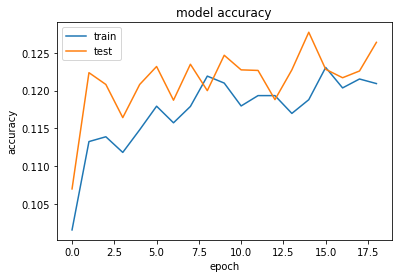

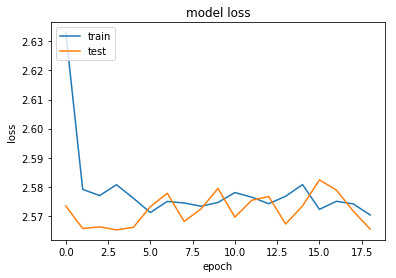

(16, 1, 1)


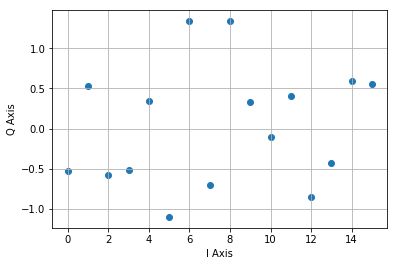

[0.523226]
SNR: 0 SER: 0.8658444444444444 Theor_SER: 0.8232078436042176
(120000, 16)
Train on 84000 samples, validate on 36000 samples
Epoch 1/200
84000/84000 [==============================] - 2s 18us/step - loss: 2.3237 - acc: 0.1520 - val_loss: 2.3007 - val_acc: 0.1519
Epoch 2/200
84000/84000 [==============================] - 0s 3us/step - loss: 2.2454 - acc: 0.1792 - val_loss: 2.2434 - val_acc: 0.1886
Epoch 3/200
84000/84000 [==============================] - 0s 3us/step - loss: 2.2392 - acc: 0.1815 - val_loss: 2.1683 - val_acc: 0.2021
Epoch 4/200
84000/84000 [==============================] - 0s 3us/step - loss: 2.2374 - acc: 0.1872 - val_loss: 2.1926 - val_acc: 0.1986
Epoch 5/200
84000/84000 [==============================] - 0s 3us/step - loss: 2.2406 - acc: 0.1860 - val_loss: 2.2725 - val_acc: 0.1925
Epoch 6/200
84000/84000 [==============================] - 0s 3us/step - loss: 2.2352 - acc: 0.1865 - val_loss: 2.1513 - val_acc: 0.2135
Epoch 7/200
84000/84000 [=================

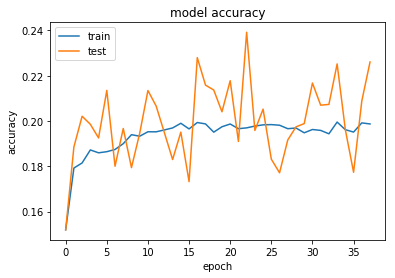

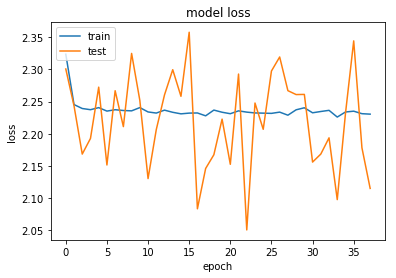

(16, 1, 1)


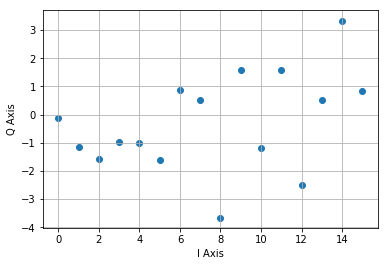

[2.9679766]
SNR: 6 SER: 0.7944916666666667 Theor_SER: 0.712087050228903
(95000, 16)
Train on 66500 samples, validate on 28500 samples
Epoch 1/200
66500/66500 [==============================] - 2s 35us/step - loss: 2.1668 - acc: 0.1791 - val_loss: 1.7624 - val_acc: 0.2643
Epoch 2/200
66500/66500 [==============================] - 0s 4us/step - loss: 1.7269 - acc: 0.2755 - val_loss: 1.7219 - val_acc: 0.2867
Epoch 3/200
66500/66500 [==============================] - 0s 4us/step - loss: 1.7073 - acc: 0.2913 - val_loss: 1.7183 - val_acc: 0.2879
Epoch 4/200
66500/66500 [==============================] - 0s 4us/step - loss: 1.6945 - acc: 0.3060 - val_loss: 1.6999 - val_acc: 0.3076
Epoch 5/200
66500/66500 [==============================] - 0s 4us/step - loss: 1.6952 - acc: 0.3162 - val_loss: 1.6718 - val_acc: 0.3214
Epoch 6/200
66500/66500 [==============================] - 0s 4us/step - loss: 1.6853 - acc: 0.3240 - val_loss: 1.6675 - val_acc: 0.3278
Epoch 7/200
66500/66500 [==================

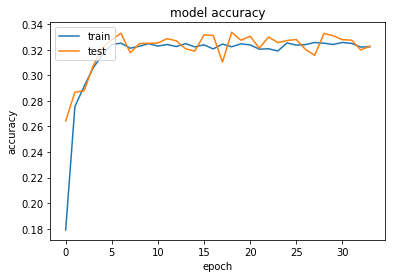

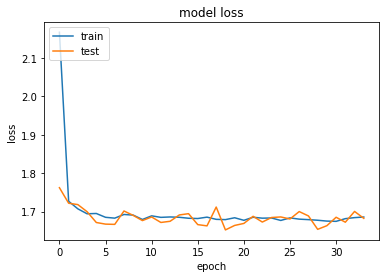

(16, 1, 1)


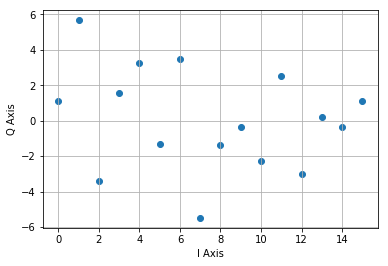

[7.8417516]
SNR: 12 SER: 0.6670421052631579 Theor_SER: 0.5075803579279314
(130000, 16)
Train on 91000 samples, validate on 39000 samples
Epoch 1/200
91000/91000 [==============================] - 4s 41us/step - loss: 1.9530 - acc: 0.2450 - val_loss: 1.4502 - val_acc: 0.3788
Epoch 2/200
91000/91000 [==============================] - 0s 5us/step - loss: 1.3869 - acc: 0.3972 - val_loss: 1.3487 - val_acc: 0.4217
Epoch 3/200
91000/91000 [==============================] - 0s 5us/step - loss: 1.3421 - acc: 0.4186 - val_loss: 1.3474 - val_acc: 0.4146
Epoch 4/200
91000/91000 [==============================] - 0s 5us/step - loss: 1.3433 - acc: 0.4193 - val_loss: 1.2968 - val_acc: 0.4434
Epoch 5/200
91000/91000 [==============================] - 0s 5us/step - loss: 1.3269 - acc: 0.4254 - val_loss: 1.3448 - val_acc: 0.4124
Epoch 6/200
91000/91000 [==============================] - 0s 5us/step - loss: 1.3288 - acc: 0.4233 - val_loss: 1.3070 - val_acc: 0.4294
Epoch 7/200
91000/91000 [===============

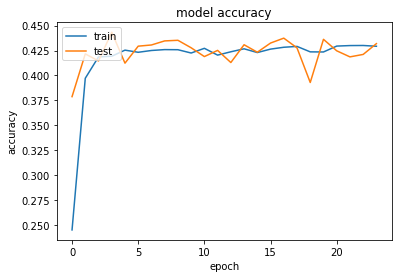

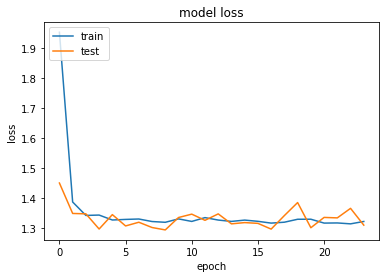

(16, 1, 1)


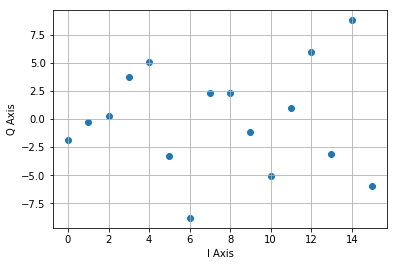

[20.493639]
SNR: 16 SER: 0.5595307692307693 Theor_SER: 0.3123019621637889
(330000, 16)
Train on 230999 samples, validate on 99001 samples
Epoch 1/200
230999/230999 [==============================] - 6s 26us/step - loss: 1.8284 - acc: 0.2570 - val_loss: 1.3625 - val_acc: 0.3754
Epoch 2/200
230999/230999 [==============================] - 2s 7us/step - loss: 1.3058 - acc: 0.3930 - val_loss: 1.2610 - val_acc: 0.4015
Epoch 3/200
230999/230999 [==============================] - 2s 7us/step - loss: 1.2396 - acc: 0.4111 - val_loss: 1.1983 - val_acc: 0.4190
Epoch 4/200
230999/230999 [==============================] - 2s 7us/step - loss: 1.2139 - acc: 0.4147 - val_loss: 1.2066 - val_acc: 0.4144
Epoch 5/200
230999/230999 [==============================] - 2s 7us/step - loss: 1.2068 - acc: 0.4286 - val_loss: 1.2128 - val_acc: 0.4209
Epoch 6/200
230999/230999 [==============================] - 2s 7us/step - loss: 1.1813 - acc: 0.4355 - val_loss: 1.1607 - val_acc: 0.4513
Epoch 7/200
230999/230999 [

230999/230999 [==============================] - 4s 16us/step - loss: 1.1113 - acc: 0.5105 - val_loss: 1.0875 - val_acc: 0.5170
Epoch 59/200
230999/230999 [==============================] - 4s 16us/step - loss: 1.1165 - acc: 0.5082 - val_loss: 1.1052 - val_acc: 0.5083
Epoch 60/200
230999/230999 [==============================] - 4s 16us/step - loss: 1.1275 - acc: 0.5026 - val_loss: 1.1282 - val_acc: 0.5035
Epoch 61/200
230999/230999 [==============================] - 4s 16us/step - loss: 1.1257 - acc: 0.5043 - val_loss: 1.1267 - val_acc: 0.4977
Epoch 62/200
230999/230999 [==============================] - 4s 17us/step - loss: 1.1202 - acc: 0.5058 - val_loss: 1.1237 - val_acc: 0.5051
Epoch 63/200
230999/230999 [==============================] - 4s 16us/step - loss: 1.1162 - acc: 0.5070 - val_loss: 1.1108 - val_acc: 0.5017
Epoch 64/200
230999/230999 [==============================] - 4s 16us/step - loss: 1.1165 - acc: 0.5073 - val_loss: 1.1216 - val_acc: 0.5025
Epoch 65/200
230999/230999

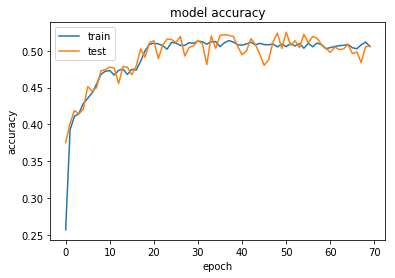

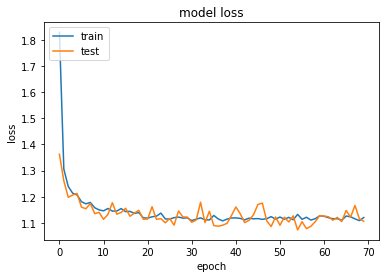

(16, 1, 1)


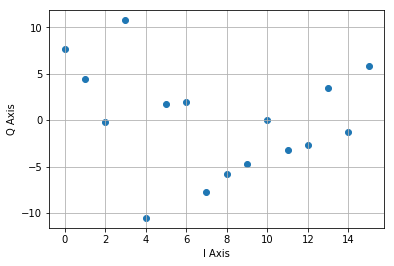

[30.709255]
SNR: 18 SER: 0.5020969696969697 Theor_SER: 0.2091143760439485
(550000, 16)
Train on 385000 samples, validate on 165000 samples
Epoch 1/200
385000/385000 [==============================] - 13s 34us/step - loss: 1.3582 - acc: 0.4199 - val_loss: 1.0786 - val_acc: 0.5100
Epoch 2/200
385000/385000 [==============================] - 6s 16us/step - loss: 1.1103 - acc: 0.4917 - val_loss: 1.0842 - val_acc: 0.5027
Epoch 3/200
385000/385000 [==============================] - 7s 17us/step - loss: 1.0976 - acc: 0.4971 - val_loss: 1.1104 - val_acc: 0.4935
Epoch 4/200
385000/385000 [==============================] - 7s 18us/step - loss: 1.0978 - acc: 0.4975 - val_loss: 1.2066 - val_acc: 0.4422
Epoch 5/200
385000/385000 [==============================] - 6s 16us/step - loss: 1.0949 - acc: 0.4964 - val_loss: 1.0647 - val_acc: 0.5127
Epoch 6/200
385000/385000 [==============================] - 6s 16us/step - loss: 1.0973 - acc: 0.4943 - val_loss: 1.0986 - val_acc: 0.4945
Epoch 7/200
385000/3

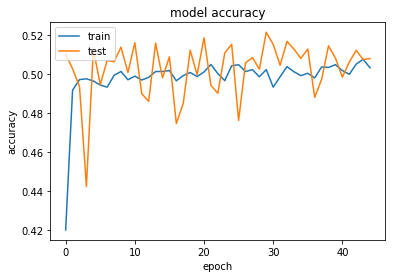

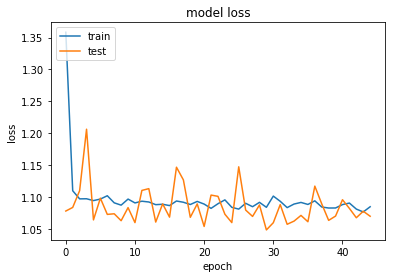

(16, 1, 1)


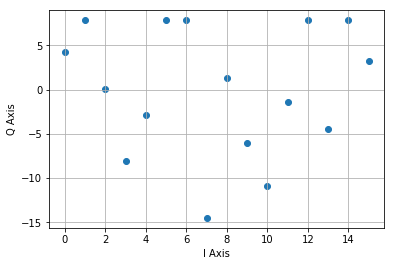

[49.722095]
SNR: 20 SER: 0.42156363636363636 Theor_SER: 0.11723145012290671
(700000, 16)
Train on 489999 samples, validate on 210001 samples
Epoch 1/200
489999/489999 [==============================] - 17s 35us/step - loss: 1.0191 - acc: 0.6123 - val_loss: 0.6576 - val_acc: 0.7123
Epoch 2/200
489999/489999 [==============================] - 10s 21us/step - loss: 0.5464 - acc: 0.7806 - val_loss: 0.4440 - val_acc: 0.8304
Epoch 3/200
489999/489999 [==============================] - 11s 23us/step - loss: 0.5121 - acc: 0.7900 - val_loss: 0.5155 - val_acc: 0.7869
Epoch 4/200
489999/489999 [==============================] - 13s 27us/step - loss: 0.5024 - acc: 0.7909 - val_loss: 0.4168 - val_acc: 0.8323
Epoch 5/200
489999/489999 [==============================] - 10s 21us/step - loss: 0.4868 - acc: 0.7958 - val_loss: 0.6429 - val_acc: 0.7296
Epoch 6/200
489999/489999 [==============================] - 10s 21us/step - loss: 0.5021 - acc: 0.7888 - val_loss: 0.6124 - val_acc: 0.7305
Epoch 7/200
4

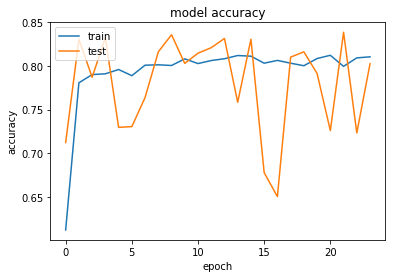

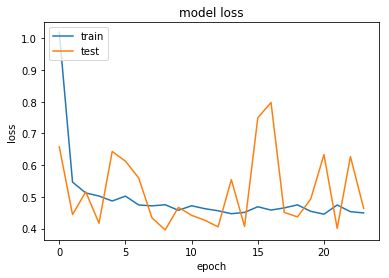

(16, 1, 1)


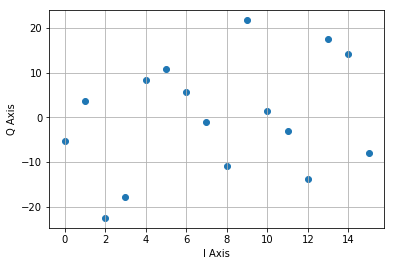

[152.76442]
SNR: 25 SER: 0.16586571428571428 Theor_SER: 0.00597813169126268


In [5]:
# Calculating SER from -4dB to 14dB SNR
EsNodB_range = [0,6,12,16,18,20,25]
N_array = [45000,120000,95000,130000,330000,550000,700000]
ser = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

for n in range(0,len(EsNodB_range)):
    
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    no_errors = 0
    
    N = N_array[n]
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
        
    test_data = []
    test_label = np.random.randint(M,size=N)
    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    pred_output = np.argmax(pred_final_signal,axis=1)
    
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = (no_errors/N).astype('float64') 
    
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('SNR:',EsNodB_range[n],'SER:',ser[n],'Theor_SER:',theor_ser[n])

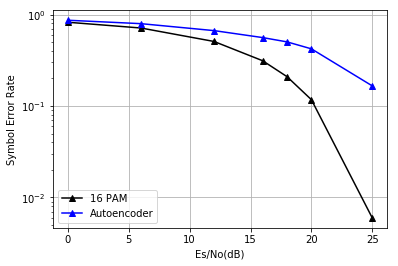

In [6]:
# ploting BER curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EsNodB_range, theor_ser, 'k^-',label='16 PAM')
plt.plot(EsNodB_range, ser, 'b^-',label='Autoencoder')
plt.yscale('log')
plt.xlabel('Es/No(dB)')
plt.ylabel('Symbol Error Rate')
#plt.ylim((10e-3,10e0))
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [7]:
ser

[0.8658444444444444,
 0.7944916666666667,
 0.6670421052631579,
 0.5595307692307693,
 0.5020969696969697,
 0.42156363636363636,
 0.16586571428571428]